# Scraping Yelp 

Yelp is a web application created to connect people with great local businesses.
It is useful for finding restaurants, bars and various types of services. 
The site features reviews of an active and well-informed local community.

Site: www.yelp.com

In this document, I describe a scraping script that extracts information about the restaurants in San Francisco from Yelp.

Also, I present a data cleaning process and a simple data analysis of restaurants by location.

### Scraping data from yelp.com

In this scraping script, I will take the following information for each San Francisco's restaurant:

* name
* neighborhood
* address
* phone
* reviews

In [1]:
# Import packages
import requests
from bs4 import BeautifulSoup

# Request header
headers = {"User-Agent": "Chrome/68.0.3440.106"}

# Request parameters
parameters = {
    'find_desc': 'Restaurants',
    'find_loc':'San Francisco CA',
    'start':'0'}

# Yelp search url
url='https://www.yelp.com/search'

# Get the number of pages return by request (Ex: 'Page 1 of 34') 
# Each page shows 30 items
response = requests.get(url, params=parameters)
# Create BeautifulSoup Object
soup = BeautifulSoup(response.text, 'html.parser')
# Extract the number of pages
string_pages = soup.findAll('div', attrs={'class':'page-of-pages arrange_unit arrange_unit--fill'})[0].text
number_of_pages = int(string_pages.split('of ')[1])

# Variable that stores the data
data = []

# Start page
pagination = 0

# For each pagination extract the items
for i in range(number_of_pages):
    
    # Produces the request and saves the response
    response=requests.get(url, params=parameters)
    # Create a Soup object
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # count 30 pages
    #count = 1
    
    print('Extract data ... page {} from {}'.format(int(pagination/30)+1, number_of_pages))
    
    # Extract the info
    for a in soup.findAll('div', attrs={'class':'media-story'}):
                
        # Validate if the info exists
        try:
            address = a.find('address').text.strip()
        except:
            address = ''

        try:
            name = a.find('a', attrs={'class':'biz-name js-analytics-click'}).text
        except:
            name = ''

        try:
            reviews = a.find('span', attrs={'class':'review-count rating-qualifier'}).text.strip().split()[0]
        except:
            reviews = ''

        try:
            phone = a.find('span', attrs={'class':'biz-phone'}).text.strip()
        except:
            phone = ''

        try: 
            neighborhood = a.find('span', attrs={'class':'neighborhood-str-list'}).text.strip()
        except:
            neighborhood = ''
        
        # Saves info in a dictionary
        info = {
        'name' : name,
        'reviews' : reviews,
        'phone' : phone,
        'address' : address,
        'neighborhood' : neighborhood
        }
        
        # saves dictionary in the data variable
        data.append(info)        
        
        # Each page shows 30 items, but the Soup Object find more (garbage)
        # To avoid some erros in processing, This code guarantees that only 30 items will be scraped
        #count += 1                
        #if count == 30: break
        
    # Increment the start item ID (pagination)
    pagination+=30
    parameters['start'] = pagination

Extract data ... page 1 from 34
Extract data ... page 2 from 34
Extract data ... page 3 from 34
Extract data ... page 4 from 34
Extract data ... page 5 from 34
Extract data ... page 6 from 34
Extract data ... page 7 from 34
Extract data ... page 8 from 34
Extract data ... page 9 from 34
Extract data ... page 10 from 34
Extract data ... page 11 from 34
Extract data ... page 12 from 34
Extract data ... page 13 from 34
Extract data ... page 14 from 34
Extract data ... page 15 from 34
Extract data ... page 16 from 34
Extract data ... page 17 from 34
Extract data ... page 18 from 34
Extract data ... page 19 from 34
Extract data ... page 20 from 34
Extract data ... page 21 from 34
Extract data ... page 22 from 34
Extract data ... page 23 from 34
Extract data ... page 24 from 34
Extract data ... page 25 from 34
Extract data ... page 26 from 34
Extract data ... page 27 from 34
Extract data ... page 28 from 34
Extract data ... page 29 from 34
Extract data ... page 30 from 34
Extract data ... pa

Here is some part of the data extract:

In [2]:
data[:5]

[{'name': 'Little Baobab',
  'reviews': '544',
  'phone': '(415) 643-3558',
  'address': '3380 19th St',
  'neighborhood': 'Mission'},
 {'name': 'The House',
  'reviews': '4354',
  'phone': '(415) 986-8612',
  'address': '1230 Grant Ave',
  'neighborhood': 'North Beach/Telegraph Hill'},
 {'name': 'Fog Harbor Fish House',
  'reviews': '4517',
  'phone': '(415) 421-2442',
  'address': 'Pier 39',
  'neighborhood': "Fisherman's Wharf"},
 {'name': 'Gary Danko',
  'reviews': '4874',
  'phone': '(415) 749-2060',
  'address': '800 N Point St',
  'neighborhood': 'Russian Hill'},
 {'name': 'Marlowe',
  'reviews': '2485',
  'phone': '(415) 777-1413',
  'address': '500 Brannan St',
  'neighborhood': 'Mission Bay'}]

Now let's convert the data to a DataFrame object:

In [3]:
from pandas import DataFrame

restaurants = DataFrame(data)

The results is:

In [4]:
# Show the ten firsts items
restaurants.head(10)

,address,name,neighborhood,phone,reviews
0,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
1,1230 Grant Ave,The House,North Beach/Telegraph Hill,(415) 986-8612,4354
2,Pier 39,Fog Harbor Fish House,Fisherman's Wharf,(415) 421-2442,4517
3,800 N Point St,Gary Danko,Russian Hill,(415) 749-2060,4874
4,500 Brannan St,Marlowe,Mission Bay,(415) 777-1413,2485
5,3870 17th St,Frances,Castro,(415) 621-3870,1416
6,974 Valencia St,Loló,Mission,(415) 643-5656,1868
7,1382 9th Ave,Ushi Taro,Inner Sunset,(415) 702-6014,39
8,652 Polk St,Brenda’s French Soul Food,Tenderloin,(415) 345-8100,9545
9,1782 Haight St,What The Cluck SF,The Haight,(415) 702-6777,53


### Data Cleaning

Before saves the data into a file, let's check if there is any null, empty or duplicate value:

In [5]:
# Check if there is any null value in DataFrame
restaurants.isnull().any().any()

False

In [6]:
# Check if there is any empty value in DataFrame
no_address = len(restaurants[restaurants['address'] == ''])
no_name = len(restaurants[restaurants['name'] == ''])
no_neighborhood = len(restaurants[restaurants['neighborhood'] == ''])
no_phone = len(restaurants[restaurants['phone'] == ''])
no_reviews = len(restaurants[restaurants['reviews'] == ''])

print('Column \t\t empty values')
print('address \t ', no_address)
print('name \t\t ', no_name)
print('neighborhood \t ', no_neighborhood)
print('phone \t\t ', no_phone)
print('reviews \t ', no_reviews)

Column 		 empty values
address 	  122
name 		  99
neighborhood 	  106
phone 		  119
reviews 	  99


As presented above, there is a lot of empty values in the data. This happens because the Yelp site does not have all the information for some restaurants.

Let's remove these items:

In [7]:
restaurants = restaurants[restaurants['address'] != '']
restaurants = restaurants[restaurants['name'] != '']
restaurants = restaurants[restaurants['neighborhood'] != '']
restaurants = restaurants[restaurants['phone'] != '']
restaurants = restaurants[restaurants['reviews'] != '']

In [8]:
# Check if there is any duplicate value in DataFrame
restaurants[restaurants.duplicated()]

,address,name,neighborhood,phone,reviews
34,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
68,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
102,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
136,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
170,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
204,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
238,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
272,3380 19th St,Little Baobab,Mission,(415) 643-3558,544
273,600 Guerrero St,Tartine Bakery & Cafe,Mission,(415) 487-2600,7295
306,3380 19th St,Little Baobab,Mission,(415) 643-3558,544


So there are various duplicated items. Most of them are about the *Little Baobab* restaurant, this happens because Yelp can promote some restaurants (Advertisement), so these promoted restaurants are shown in all pages,  and the scraping script captures them several times.

Let's remove duplicate items:

In [9]:
restaurants.drop_duplicates(inplace=True)

For a better presentation, let's change the columns order in our dataset.

In [10]:
restaurants = restaurants[['name', 'neighborhood', 'address', 'phone', 'reviews']]
restaurants.head(5)

,name,neighborhood,address,phone,reviews
0,Little Baobab,Mission,3380 19th St,(415) 643-3558,544
1,The House,North Beach/Telegraph Hill,1230 Grant Ave,(415) 986-8612,4354
2,Fog Harbor Fish House,Fisherman's Wharf,Pier 39,(415) 421-2442,4517
3,Gary Danko,Russian Hill,800 N Point St,(415) 749-2060,4874
4,Marlowe,Mission Bay,500 Brannan St,(415) 777-1413,2485


At the end, we have 949 restaurants in our dataset.

The last step is to convert the columns for the correct type.

In [11]:
restaurants.dtypes

name            object
neighborhood    object
address         object
phone           object
reviews         object
dtype: object

We can see that the ***reviews*** column is treated as a string type (object), let's convert it to a numeric type (int):

In [12]:
restaurants['reviews'] = restaurants['reviews'].astype(int)
restaurants.dtypes

name            object
neighborhood    object
address         object
phone           object
reviews          int32
dtype: object

Finally, let's save the data into a CSV file:

In [13]:
restaurants.to_csv('datasets/yelp_restaurants_sanFranscisco.csv', index=False)

## Data Analysis

Now I present a simple analysis of the restaurant's data.

### Top 10 reviewed restaurants

Let's see the ten restaurants with more reviews:

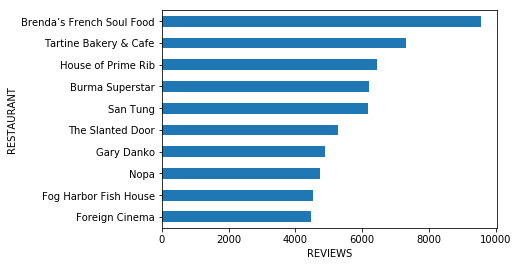

In [14]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

# Get top 10 restaurants
top10 = restaurants[['name', 'reviews']].sort_values('reviews',ascending=False).head(10).sort_values('reviews')

# Plot 
top10.plot.barh(legend=False)
plt.yticks(np.arange(10), top10.name.values)
plt.ylabel('RESTAURANT')
plt.xlabel('REVIEWS')
plt.show()

The *Brenda's French Soul Food* is the restaurant with more reviews.

### Neighborhood with more restaurants

Let's take the 10 neighborhoods with more restaurants in San Francisco.

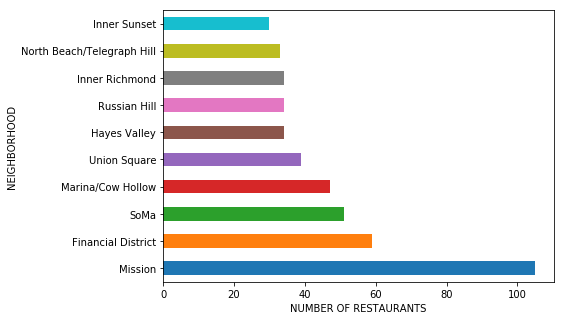

In [15]:
top_neighbor = restaurants['neighborhood'].value_counts().head(10)
top_neighbor.plot.barh(figsize=(7,5))
plt.xlabel('NUMBER OF RESTAURANTS')
plt.ylabel('NEIGHBORHOOD')
plt.show()

The *Mission* is the neighborhood with more restaurants. 

But if we consisder all restaurants, the proportion (%) is:

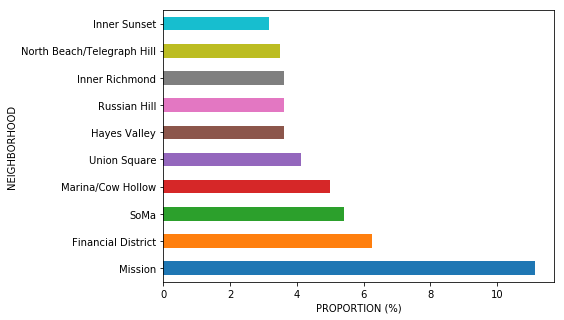

In [16]:
(restaurants['neighborhood'].value_counts(normalize=True).head(10)*100).plot.barh(figsize=(7,5))
plt.xlabel('PROPORTION (%)')
plt.ylabel('NEIGHBORHOOD')
plt.show()

# Conclusions

This document described a scraping script for yelp.com, followed by a data cleaning and analysis procedures.

These tasks could be done for any other type of information from Yelp.